In [ ]:
#inslatlling all the tools/frameworks/libraries
!pip install bnlp_toolkit

In [ ]:
#importing all necessari libraries . For tokenization we will use bnlp tokenizer and create our own embedder
from bnlp import NLTKTokenizer
import string
from bnlp import CleanText
import json
import random

from gensim.models import Word2Vec
from sklearn.decomposition import PCA
from matplotlib import pyplot as plt
import matplotlib.font_manager as fm

import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout,Concatenate, Activation, Dot
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import tensorflow as tf
from keras.utils import to_categorical

import matplotlib.pyplot as plt
import keras
from keras.models import Model
from keras.layers import Input,BatchNormalization
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.layers import LSTM, Dropout
from tensorflow.keras.models import load_model

In [ ]:
tokenizer = NLTKTokenizer()

In [ ]:
def find_index(word):

  #word_to_find = 'লাইনশেষ'
  word_to_find = word
  if word_to_find in word_index:
    token_id =word_index[word_to_find]

  return token_id



# Train our Embedder


In [ ]:


clean_text = CleanText(
   fix_unicode=True,
   unicode_norm=True,
   unicode_norm_form="NFKC",
   remove_url=False,
   remove_email=False,
   remove_emoji=True,
   remove_number=False,
   remove_digits=False,
   remove_punct=False,
   replace_with_url="<URL>",
   replace_with_email="<EMAIL>",
   replace_with_number="<NUMBER>",
   replace_with_digit="<DIGIT>",
   replace_with_punct = "<PUNC>"
)


def read_file(file_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        text = file.read()
    return text

# Read story and novel text
story_text = read_file('/content/storty_text.txt')
novel_text = read_file('/content/novel_text.txt')
poem_text = read_file('/content/poem_text.txt')
stp_word = read_file('/content/benglai_stopwords.txt')
# Combine the text for training
combined_text = story_text + '\n' + novel_text + '\n' + poem_text + '\n' + stp_word + '>' + '<'

clean_text = clean_text(combined_text)
print(combined_text[:50])
#print(clean_text[:50])
# Tokenization using bnlp_toolkit
new_poem_txt = combined_text.replace('\n', ' লাইনশেষ ')
new_poem_txt = new_poem_txt.replace('...', ' কবিতাশেষ ')

tokenizer = NLTKTokenizer()
tokenized_text = tokenizer.word_tokenize(new_poem_txt)

# Example of tokenized text
print(tokenized_text[:500])  # Displaying the first 5 tokens



বাংলাদেশের আকাশে আজ চাঁদ দেখা যায় নি।
হাফ ছেড়ে বাঁ
['বাংলাদেশের', 'আকাশে', 'আজ', 'চাঁদ', 'দেখা', 'যায়', 'নি', '।', 'লাইনশেষ', 'হাফ', 'ছেড়ে', 'বাঁচলাম', '।', 'একটা', 'দিন', 'অতিরিক্ত', 'পাওয়া', 'গেল', '।', 'আজ', 'শরীর', 'কুলাচ্ছে', 'না', '।', 'কিছু', 'কেনাকাটা', 'বাকী', 'ছিল', ',', 'বউ', 'এর', 'শাড়ি', 'চেঞ্জ', 'করতে', 'হবে', '।', 'সব', 'কাল', 'করা', 'যাবে', '।', 'আপাতত', 'হাতে', 'ধরা', 'মাছ', 'নিয়েই', 'বাড়ি', 'ফেরা', 'যাক', '।', 'লাইনশেষ', 'বাড়িতে', 'পা', 'রেখে', 'বুঝলাম', 'বেজায়', 'ভুল', 'হয়ে', 'গেছে', '।', 'এই', 'রাতে', 'মাছ', 'ক্রয়', 'করার', 'ব্যাপারটা', 'আমার', 'স্ত্রী', 'মোটেও', 'স্বাভাবিক', 'ভাবে', 'নেয়', 'নি', '।', 'কোন', 'নারীই', 'রাতে', 'মাছ', 'ক্রয়কে', 'ভালো', 'চোখে', 'দেখে', 'না', '।', 'রাত্রীকালীন', 'মাছ', 'সংসারের', 'সুখ-শান্তি', 'নাশক', '।', 'এই', 'একই', 'বিষয়-বস্তু', 'নিয়ে', 'বাবা-মার', 'মধ্যেও', 'কথা', 'কাটাকাটি', 'কম', 'হয়', 'নি', '।', 'এইসব', 'দেখেই', 'আমি', 'বড়', 'হয়ছি', 'এবং', 'কোন', 'এক', 'কুক্ষণে', 'নিজেই', 'সেই', 'ভুল', 'করে', 'বসেছি', '।', 'লাইনশেষ', 'প্রতিটি', '

In [ ]:
#creating our vocab dictionary and save it for reuse
word_index = {word: index for index, word in enumerate(set(tokenized_text), start=1)}
# Your dictionary
my_dict = word_index

# Save the dictionary to a file
with open('word_index.json', 'w') as json_file:
    json.dump(my_dict, json_file)

In [ ]:
end_token_id = find_index('লাইনশেষ')
print('end token id : ' + str(end_token_id))
seq_start_token_id = find_index('>')
print('sequence start token id : ' + str(seq_start_token_id))
seq_end_token_id = find_index('<')
print('sequence end token id : ' + str(seq_end_token_id ))

end token id : 7110
sequence start token id : 13626
sequence end token id : 9838


In [ ]:
#train and save our embedder . we will use cbow approach for training our embedder model

# Define and train Word2Vec model
model = Word2Vec(sentences=[tokenized_text], vector_size=50, window=3, min_count=1, workers=5, sg=0, epochs=100)

# Save the trained model
model.save('word2vec_com_cbow_v1.bin')

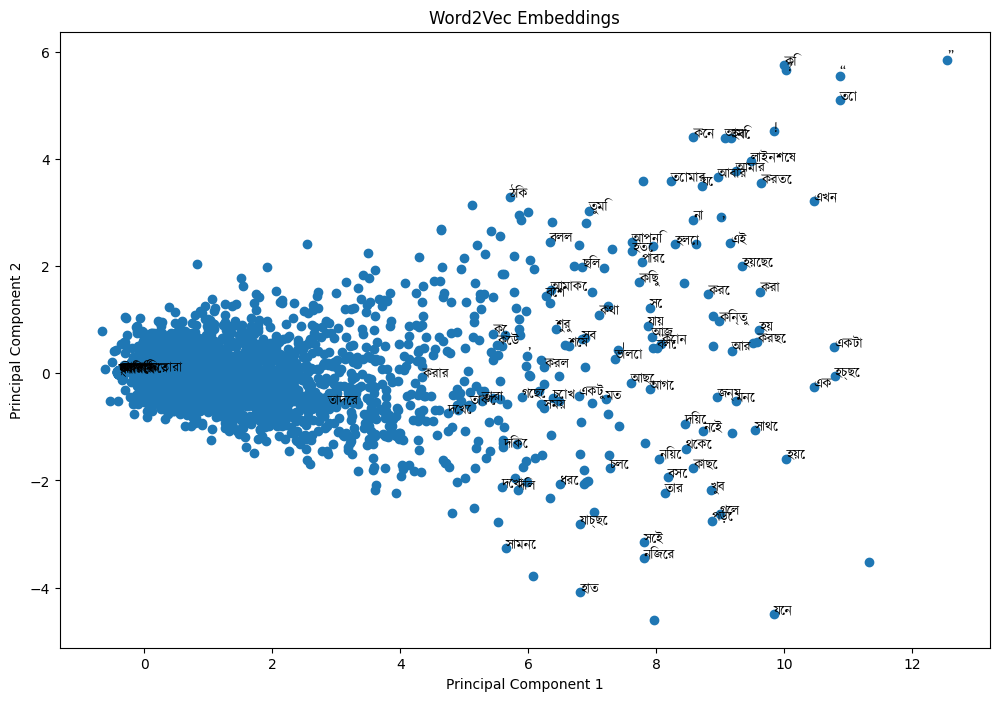

Vocabulary: ['।', 'লাইনশেষ', ',', 'না', '?', '“', '”', 'করে', 'তার', 'সে', 'এই', 'থেকে', 'আমি', 'মনে', 'আর', 'কথা', 'আমার', 'আছে', 'একটা', 'যেন', 'কোন', 'হবে', 'কি', 'কিন্তু', 'সাথে', 'হয়ে', 'হচ্ছে', 'করতে', 'নিয়ে', 'বলে', 'সেই', '!', 'গেল', 'হয়', 'জন্য', 'এক', 'নেই', 'যে', 'কিছু', 'দিয়ে', 'দিকে', 'মত', 'সব', 'করছে', 'হয়েছে', 'কী', 'করল', 'দ্বিরেফ', 'খুব', 'হলো', 'তো', 'যায়', 'আলকানতারা', 'তোমার', 'ছিল', 'গেছে', 'করা', 'যাচ্ছে', 'ওয়ালিদ', 'কেউ', 'আবার', 'সময়', 'এখন', 'আপনি', 'আমাকে', 'চোখ', 'সামনে', 'নিজের', 'বেশ', 'কেন', ';', 'বসে', 'আলফি', 'তাকে', 'দিল', 'তাদের', 'দ্বিরেফের', 'বলল', 'চলে', 'তুমি', 'কাছে', 'শুরু', 'শেষ', 'আগে', 'হাত', 'ভালো', 'ঠিক', 'দেখে', 'হতে', 'দেখা', '’', 'আজ', 'করার', 'একটু', 'পড়ে', 'কে', 'তারা', 'ধরে', 'পারে', 'ডাবরির', 'করেছে', 'এমন', 'দাঁড়িয়ে', 'মানুষ', 'যাবে', 'মুখে', 'তাই', 'আপনার', 'নয়', 'কাজ', 'চোখে', 'নৈঋত', 'মুখ', 'থাকে', 'পর', 'মাথা', 'বের', 'হাতে', 'প্রশ্ন', 'তবে', 'দিতে', 'বড়', 'কখনো', 'হঠাৎ', 'ফিকটাস', 'শুধু', 'বুঝতে', 'তা', 'অনেক', 'বাড়ি', 'এসে', '

In [ ]:
#visualize our words graph
vocab = list(model.wv.index_to_key)
vectors = model.wv[vocab]

# Reduce the dimensionality using PCA for plotting
pca = PCA(n_components=2)
result = pca.fit_transform(vectors)

# Plot the Word2Vec embeddings
plt.figure(figsize=(12, 8))
plt.scatter(result[:, 0], result[:, 1])
plt.rcParams['font.family'] =  'DejaVu Sans'
# Annotate each point with the corresponding word
prop = fm.FontProperties(fname='kalpurush.ttf')
for i, word in enumerate(vocab[:100]):
    plt.annotate(word, xy=(result[i, 0], result[i, 1]),fontproperties=prop)

plt.title('Word2Vec Embeddings')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()

# Display the vocabulary
print("Vocabulary:", vocab)

In [ ]:
#finding our similar words
#vocab
def find_similar_words(word, topn=5):
    similar_words = model.wv.similar_by_word(word, topn=topn)
    return similar_words

In [ ]:
similar = find_similar_words('সে', topn=5)
similar

[('প্রকাশ', 0.9313871264457703),
 ('টিটকারি', 0.9078040719032288),
 ('আত্মহত্যা', 0.9039733409881592),
 ('দায়িত্বের', 0.8973550200462341),
 ('সামান্যই', 0.8931281566619873)]

# Text Preprocessing


In [ ]:
#load our dictionary

# Load the dictionary from the file
with open('/content/word_index (1).json', 'r') as json_file:
    word_index = json.load(json_file)


In [ ]:
def load_text_data(file_path):
    """
    Load text data from a TXT file.

    Parameters:
    - file_path (str): The path to the TXT file.

    Returns:
    - str: The text data read from the file.
    """
    try:
        with open(file_path, 'r', encoding='utf-8') as file:
            text_data = file.read()
        return text_data
    except FileNotFoundError:
        print(f"Error: File not found at '{file_path}'.")
        return None
    except Exception as e:
        print(f"Error: Unable to read the file at '{file_path}'.")
        print(f"Details: {e}")
        return None

In [ ]:
def load_bengali_stopwords(file_path):
    """
    Load Bengali stopwords from a TXT file.

    Parameters:
    - file_path (str): The path to the TXT file containing stopwords.

    Returns:
    - list: The list of Bengali stopwords.
    """
    try:
        with open(file_path, 'r', encoding='utf-8') as file:
            stopwords = file.read().splitlines()
        return stopwords
    except FileNotFoundError:
        print(f"Error: File not found at '{file_path}'.")
        return None
    except Exception as e:
        print(f"Error: Unable to read the file at '{file_path}'.")
        print(f"Details: {e}")
        return None

In [ ]:
# Load your Word2Vec model
word2vec_model = Word2Vec.load("/content/word2vec_com_cbow_v1.bin")

# Load and preprocess your text data
story_text = load_text_data("/content/storty_text.txt")
novel_text = load_text_data("/content/novel_text.txt")
poem_text = load_text_data("/content/poem_text.txt")

bengali_stopwords = load_bengali_stopwords("/content/benglai_stopwords.txt")

#tokenizer = NLTKTokenizer()

# Tokenize using bnlp and NLTK tokenizer
#story_tokens = tokenizer.word_tokenize(story_text)
#novel_tokens = tokenizer.word_tokenize(novel_text)
#poem_tokens = tokenizer.word_tokenize(poem_text)

In [ ]:
poem_text = poem_text.replace('\n', ' লাইনশেষ ').replace('...', ' কবিতাশেষ ')

In [ ]:
end_token_id = find_index('লাইনশেষ')
print('end token id : ' + str(end_token_id))
seq_start_token_id = find_index('>')
print('sequence start token id : ' + str(seq_start_token_id))
seq_end_token_id = find_index('<')
print('sequence end token id : ' + str(seq_end_token_id ))

end token id : 7110
sequence start token id : 13626
sequence end token id : 9838


In [ ]:
inp_seq =[]

tokens = tokenizer.word_tokenize(poem_text)
tokens = [word for word in tokens if word in word_index]
replaced_text = ' '.join(str(word_index.get(word, word)) for word in tokens)
token_list = []
current_sequence = []

for token in replaced_text.split():
  add_token = int(token)
  token_list.append(add_token)

for token_id in token_list:
  #print(token_id)

  current_sequence.append(token_id)

    # Check if the current token ID is one of the ending tokens
  if token_id == end_token_id:
        # Add the current sequence to the list of sequences
    inp_seq.append(current_sequence)

    current_sequence = []

In [ ]:
#inp_seq

In [ ]:
#we will add some random lines from our text to avoid overfitting issue
num_random_sequences = 200
selected_input_sequences = random.sample(inp_seq, num_random_sequences)
inp_seq += selected_input_sequences
modified_sequence = [sequence[:-1] for sequence in inp_seq]
max_sequence_length = max([len(seq) for seq in modified_sequence])

In [ ]:
input_seq = []
target_seq = []
for i in range(len(modified_sequence)-1):
  input_seq.append(modified_sequence[i])
  target_seq.append(modified_sequence[i+1])

end token id : 7110
sequence start token id : 13626
sequence end token id : 9838


In [ ]:
dc_inp_sq = [[seq_start_token_id] + inner_list for inner_list in target_seq]
dc_out_sq = [target_list + [seq_end_token_id] for target_list in target_seq]
input_sequences = pad_sequences(input_seq, padding='post',maxlen = max_sequence_length)
decoder_input = pad_sequences(dc_inp_sq, padding='post',maxlen = max_sequence_length)
decoder_output = pad_sequences(dc_out_sq, padding='post',maxlen = max_sequence_length)

In [ ]:
type(decoder_output)

numpy.ndarray

In [ ]:
embedding_layer_weights = word2vec_model.wv.vectors
print(embedding_layer_weights.shape)
vocab_size = len(word_index)
print(vocab_size)

(17492, 50)
17492


# Model Building(Decoder Encoder with teaching force)

In [ ]:
# Encoder
encoder_inputs = Input(shape=(max_sequence_length,))
embedding_layer = Embedding(input_dim=vocab_size, output_dim=50, weights=[embedding_layer_weights], trainable=False)
encoder_embedding = embedding_layer(encoder_inputs)

# Add Dropout to Encoder LSTM
encoder_lstm = LSTM(units=100, return_state=True) #dropout=0.5, recurrent_dropout=0.5
encoder_outputs, state_h, state_c = encoder_lstm(encoder_embedding)
#encoder_outputs = BatchNormalization()(encoder_outputs)
encoder_states = [state_h, state_c]

# Decoder
decoder_inputs = Input(shape=(max_sequence_length,))
decoder_embedding = embedding_layer(decoder_inputs)

# Add Dropout to Decoder LSTM
decoder_lstm = LSTM(units=100, return_sequences=True, return_state=True)#, dropout=0.5, recurrent_dropout=0.5
decoder_outputs, _, _ = decoder_lstm(decoder_embedding, initial_state=encoder_states)
decoder_outputs= Dropout(0.5)(decoder_outputs)
decoder_outputs = BatchNormalization()(decoder_outputs)

decoder_dense = Dense(vocab_size, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)

# Model
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)
# Compile the model with specific learning rate
learning_rate = 0.01
optimizer = Adam(learning_rate=learning_rate)
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
# Print model summary
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 35)]                 0         []                            
                                                                                                  
 input_1 (InputLayer)        [(None, 35)]                 0         []                            
                                                                                                  
 embedding (Embedding)       (None, 35, 50)               874600    ['input_1[0][0]',             
                                                                     'input_2[0][0]']             
                                                                                                  
 lstm (LSTM)                 [(None, 100),                60400     ['embedding[0][0]']       

In [ ]:
# Define callbacks
checkpoint = ModelCheckpoint("best_model.h5", save_best_only=True)
early_stopping = EarlyStopping(monitor='loss', patience=5)
# Fit the model with teacher forcing
epochs = 200
batch_size = 48

history = model.fit(
    [input_sequences,decoder_input],
    decoder_output,
    epochs=epochs,
    batch_size=batch_size,
    validation_split=0.2,
    callbacks=[checkpoint, early_stopping,]
)

model.save('poem_without_attention_v2.h5')

history_dict = history.history
# Save it under the form of a json file
json.dump(history_dict, open('history.json', 'w'))

Epoch 1/200
39/39 [==============================] - 60s 1s/step - loss: 3.6936 - accuracy: 0.7412 - val_loss: 2.2399 - val_accuracy: 0.7790
Epoch 2/200
39/39 [==============================] - 53s 1s/step - loss: 1.7654 - accuracy: 0.7801 - val_loss: 1.8143 - val_accuracy: 0.7755
Epoch 3/200
39/39 [==============================] - 53s 1s/step - loss: 1.7082 - accuracy: 0.7809 - val_loss: 1.9512 - val_accuracy: 0.7640
Epoch 4/200
39/39 [==============================] - 50s 1s/step - loss: 1.6570 - accuracy: 0.7824 - val_loss: 1.8856 - val_accuracy: 0.7719
Epoch 5/200
39/39 [==============================] - 53s 1s/step - loss: 1.6194 - accuracy: 0.7829 - val_loss: 1.8062 - val_accuracy: 0.7754
Epoch 6/200
39/39 [==============================] - 53s 1s/step - loss: 1.5991 - accuracy: 0.7823 - val_loss: 1.7243 - val_accuracy: 0.7758
Epoch 7/200
39/39 [==============================] - 55s 1s/step - loss: 1.5795 - accuracy: 0.7832 - val_loss: 1.6343 - val_accuracy: 0.7788
Epoch 8/200
3

In [ ]:
def plot_training_accuracy(history, savePlot=False, title = "fig"):
    plt.plot(history['loss'])
    plt.plot(history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train loss', 'validation loss'], loc='upper left')
    if savePlot:
        plt.savefig(title+'_loss.png')
    plt.show()

    plt.plot(history['accuracy'])
    plt.plot(history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    if savePlot:
        plt.savefig(title+'_acc.png')
    plt.show()

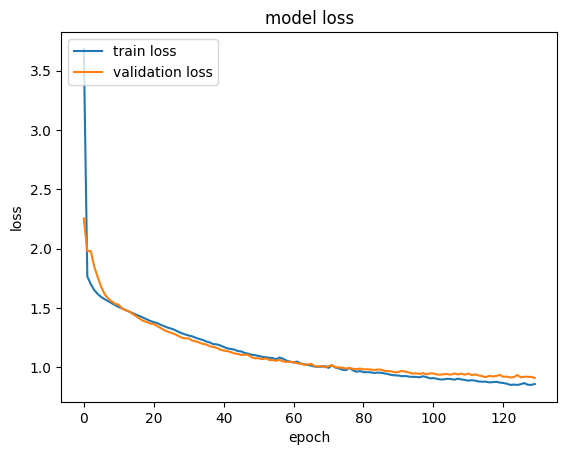

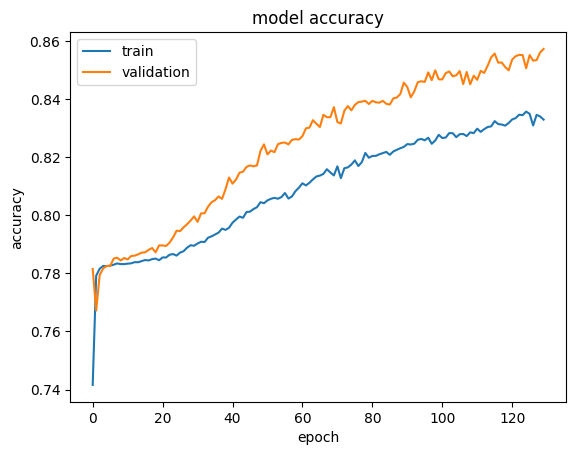

In [ ]:
plot_training_accuracy(history.history, savePlot=False, title = "fig")

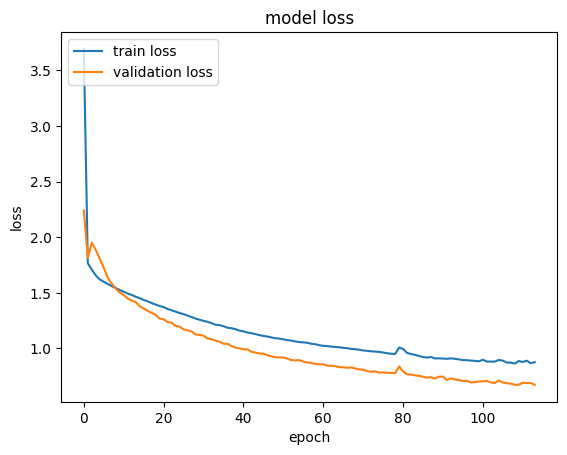

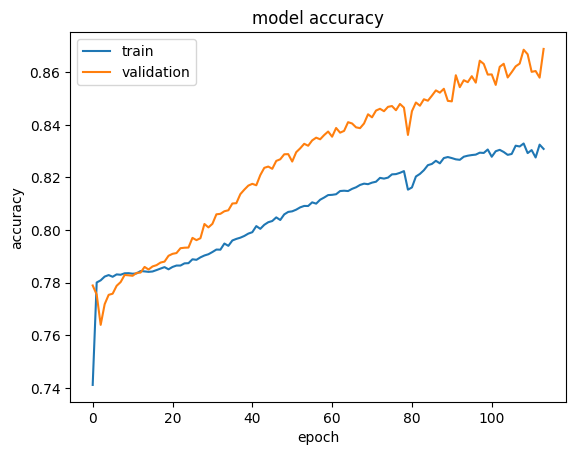

In [ ]:
plot_training_accuracy(history.history, savePlot=False, title = "fig")

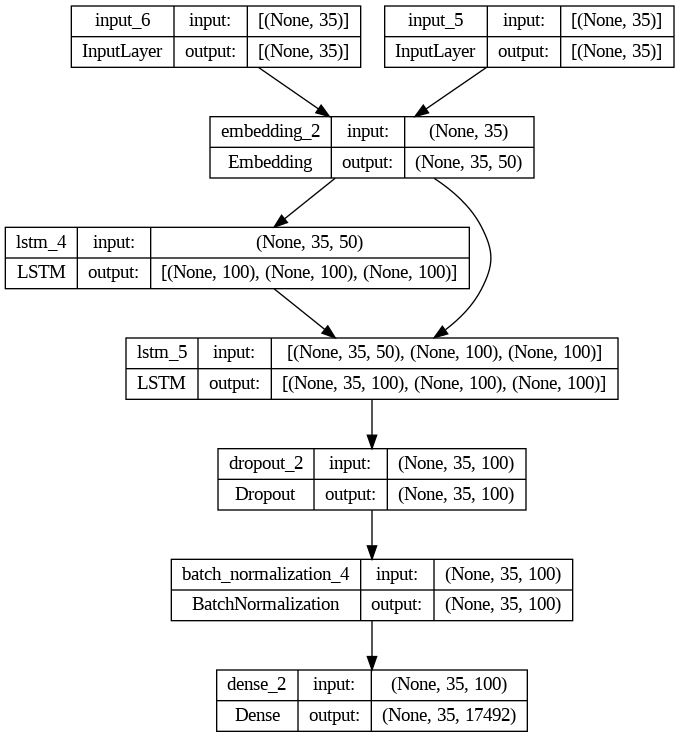

In [ ]:
tf.keras.utils.plot_model(model, to_file='model_without_attention.png', show_shapes=True)

In [ ]:
#from tensorflow.keras.models import load_model
model = load_model('/content/poem_without_attention_v2.h5')
for layer in model.layers:
  print(layer.name)

input_2
input_1
embedding
lstm
lstm_1
dropout
batch_normalization
dense


In [ ]:
#now save our encoder model
# Encoder
encoder_input = model.input[0]
_, state_h, state_c = model.layers[3].output
encoder_states = [state_h, state_c]
encoder_model = Model(encoder_input, # input encoder model
                      encoder_states)# output encoder mode

In [ ]:
# Decoder
decoder_input = model.input[1]
embeded_decoder = model.layers[2]
embeded_decoder = embeded_decoder(decoder_input)
decoder_state_h = Input(shape=(100), name="input_3")
decoder_state_c = Input(shape=(100), name="input_4")
decoder_state_inputs = [decoder_state_h,decoder_state_c]
decoder_lstm = model.layers[4]
decoder_outputs, state_h, state_c = decoder_lstm(embeded_decoder, initial_state=decoder_state_inputs)
decoder_states = [state_h,state_c]

# decoder outputs
dropout_out = model.layers[5]
dropout_out = dropout_out(decoder_outputs)
batch_norm = model.layers[6]
dropout_out = batch_norm(dropout_out)
decoder_dense = model.layers[7]
decoder_outputs = decoder_dense(dropout_out)

decoder_model = Model([decoder_input]+decoder_state_inputs, # input decoder model
                          [decoder_outputs]+decoder_states) #

# Inference(Encoder decoder with teaching force)

In [ ]:
def inference_without_attention(sentence,max_sequence_length,num_line):

    initial = sentence
    for i in range(num_line):
      sentence = sentence

    # Input the sequence to encoder_model and get the final timestep encoder_states(Hidden and cell state)
      tokens = tokenizer.word_tokenize(sentence)
      encoded_seed = [word_index.get(word, word) for word in tokens]
      max_sequence_length = max_sequence_length
      padded_seed = pad_sequences([encoded_seed], maxlen=max_sequence_length, padding='post')
      state_h, state_c = encoder_model.predict(padded_seed)

    # Define target word
      target_word = np.zeros((1,1))
    # :1 , :2
      target_word[0,0] = seq_start_token_id

      stop_condition=False
    # Define output sentence string
      sent=''
      step_size=0

    #index_to_words = {idx: word for word, idx in eng_text_tokenizer.word_index.items()}
      while not stop_condition:

        # We are giving a target_word which represents  and encoder_states to the decoder_model
        # for the first step and the output at the previous step for the next steps after the first
          output, state_h, state_c = decoder_model.predict([target_word, state_h, state_c])

        # As the target word length is 1. We will only have one time step
        #encoder_state_value = [state_h, state_c]
        # Find the word which the decoder predicted with max_probability
          output = np.argmax(output,-1)
        # The output is a integer sequence, to get back the word. We use our lookup table reverse_dict
        #sent = sent+' '+str(index_to_words.get(int(output)))
          word = [word for word, index in word_index.items() if index == output][0]
          sent = sent +' '+ word
          step_size+=1
        # If the max_length of the sequence is reached or the model predicted 2 () stop the model
          if step_size>max_sequence_length or output==seq_end_token_id:
            stop_condition = True
        # Define next decoder input
          target_word=output.reshape(1,1)

      sentence = sent
      #sentence = sentence.encode('utf-8')

      initial = initial + '\n' + sent
      #sentence = initial

    return initial

In [ ]:
inference_without_attention('হাতে হাত রেখে পাড়ি দেব বিপ্লবী', max_sequence_length,4)

1/1 [==============================] - 0s 24ms/step


'হাতে হাত রেখে পাড়ি দেব বিপ্লবী\n হঠাৎ হাতের দুপুরে জোড়াল উড়তে চেয়েছিল নিলাম <\n হঠাৎ হাতের দুপুরে জোড়াল উড়তে চেয়েছিল নিলাম <\n হঠাৎ হাতের দুপুরে জোড়াল উড়তে চেয়েছিল নিলাম <\n হঠাৎ হাতের দুপুরে জোড়াল উড়তে চেয়েছিল নিলাম <'

In [ ]:
seed_text = 'হাতে হাত রেখে পাড়ি দেব বিপ্লবী'
result = seed_text
seed = seed_text
for _ in range(1):
    decode_index = []
    seed = seed
    tokens = tokenizer.word_tokenize(seed)
    encoded_seed = [word_index.get(word, word) for word in tokens]
    max_sequence_length = max_sequence_length
    padded_seed = pad_sequences([encoded_seed], maxlen=max_sequence_length, padding='post')

    context_vector = encoder_model.predict(padded_seed)

    target_seq = np.zeros((1, max_sequence_length))
    target_seq[0][0] = seq_start_token_id

    stop_condition = False

    it = 0
    pred_line = ''
    while not stop_condition:
        output_tokens = decoder_model.predict([target_seq, context_vector])
        print(output_tokens)
        sampled_token = np.argmax(output_tokens[0, it, :])
        decode_index.append(sampled_token)

        word = [word for word, index in word_index.items() if index == sampled_token][0]
        pred_line += ' ' + word

        print(pred_line)

        if sampled_token == token_id or it == (max_sequence_length - 1):
            stop_condition = True

        target_seq[0][it + 1] = sampled_token
        it += 1

    result += '\n' + pred_line
    seed = pred_line

result


1/1 [==============================] - 0s 366ms/step
[array([[[1.10349620e-05, 1.11615181e-03, 2.55591003e-05, ...,
         1.93428914e-05, 2.59825374e-05, 2.42351616e-05],
        [9.99986291e-01, 1.54448523e-10, 3.63411246e-11, ...,
         6.87815039e-12, 3.62441466e-11, 3.81843862e-11],
        [9.99758542e-01, 2.00758923e-11, 1.54396140e-08, ...,
         3.46660547e-12, 1.60435469e-08, 1.51207828e-08],
        ...,
        [9.99962330e-01, 2.53899901e-13, 2.74484679e-09, ...,
         4.54784356e-14, 2.81118284e-09, 2.70704326e-09],
        [9.99984741e-01, 7.30711200e-14, 1.09260945e-09, ...,
         2.40324101e-14, 1.11217202e-09, 1.09125564e-09],
        [9.99994993e-01, 2.22761872e-14, 3.61610658e-10, ...,
         1.23454705e-14, 3.63945957e-10, 3.69110104e-10]]], dtype=float32), array([[-1.86850666e-04,  1.00000000e+00, -1.00000000e+00,
         9.39151168e-15, -7.61372685e-01,  7.60737121e-01,
         7.30503857e-01,  5.66478237e-04,  7.65767217e-01,
        -7.6149308

TypeError: list indices must be integers or slices, not tuple

# Model building(encoder decoder with attention and teacher forcing)


In [ ]:
# Encoder
encoder_inputs = Input(shape=(max_sequence_length,))
embedding_layer = Embedding(input_dim=vocab_size, output_dim=50, weights=[embedding_layer_weights], trainable=False)
encoder_embedding = embedding_layer(encoder_inputs)

# Add Dropout to Encoder LSTM
encoder_lstm = LSTM(units=100, return_state=True,return_sequences = True) #dropout=0.5, recurrent_dropout=0.5
encoder_outputs, state_h, state_c = encoder_lstm(encoder_embedding)
#encoder_outputs = BatchNormalization()(encoder_outputs)
encoder_states = [state_h, state_c]

# Decoder
decoder_inputs = Input(shape=(max_sequence_length,))
decoder_embedding = embedding_layer(decoder_inputs)

# Add Dropout to Decoder LSTM
decoder_lstm = LSTM(units=100, return_sequences=True, return_state=True)#, dropout=0.5, recurrent_dropout=0.5
decoder_outputs, _, _ = decoder_lstm(decoder_embedding, initial_state=encoder_states)

#attention
dot_prod = Dot(axes=(2, 2))([decoder_outputs, encoder_outputs])
attention = Activation('softmax', name='attention')
attention_vec = attention(dot_prod)
context = Dot(axes=(2, 1))([attention_vec, encoder_outputs])
conc_out = Concatenate()([context, decoder_outputs])

decoder_outputs= Dropout(0.6)(conc_out)
decoder_outputs = BatchNormalization()(decoder_outputs)

decoder_dense = Dense(vocab_size, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)

# Model
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)
# Compile the model with specific learning rate
learning_rate = 0.01
optimizer = Adam(learning_rate=learning_rate)
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
# Print model summary
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 35)]                 0         []                            
                                                                                                  
 input_1 (InputLayer)        [(None, 35)]                 0         []                            
                                                                                                  
 embedding (Embedding)       (None, 35, 50)               874600    ['input_1[0][0]',             
                                                                     'input_2[0][0]']             
                                                                                                  
 lstm (LSTM)                 [(None, 35, 100),            60400     ['embedding[0][0]']       

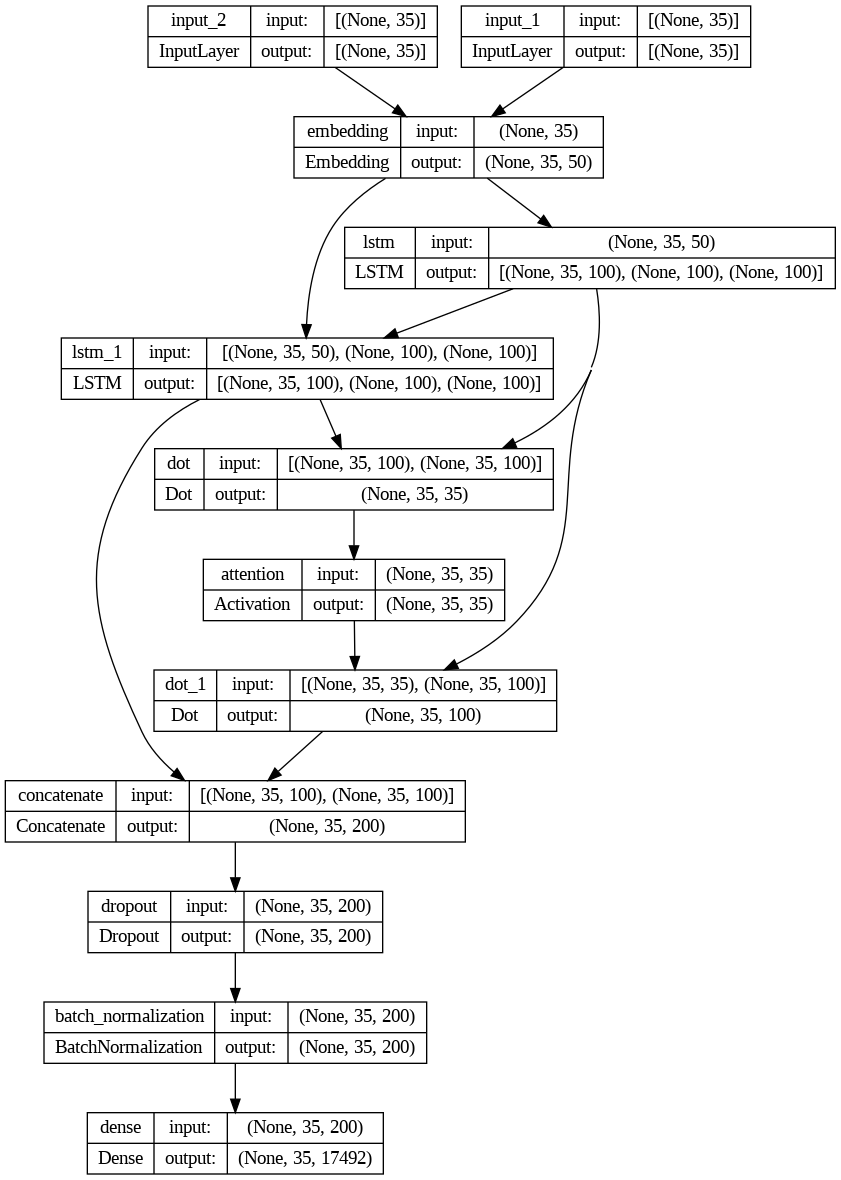

In [ ]:
tf.keras.utils.plot_model(model, to_file='model_with_attention.png', show_shapes=True)

In [ ]:
# Define callbacks
checkpoint = ModelCheckpoint("best_model.h5", save_best_only=True)
early_stopping = EarlyStopping(monitor='loss', patience=5)
# Fit the model with teacher forcing
epochs = 60
batch_size = 48

history = model.fit(
    [input_sequences,decoder_input],
    decoder_output,
    epochs=epochs,
    batch_size=batch_size,
    validation_split=0.2,
    callbacks=[checkpoint, early_stopping,]
)

model.save('poem_with_luoang_attention_v2.h5')

history_dict = history.history
# Save it under the form of a json file
json.dump(history_dict, open('att_history.json', 'w'))

Epoch 1/60
34/34 [==============================] - 85s 3s/step - loss: 0.9131 - accuracy: 0.8197 - val_loss: 1.8058 - val_accuracy: 0.7960
Epoch 2/60
34/34 [==============================] - 63s 2s/step - loss: 0.9078 - accuracy: 0.8207 - val_loss: 1.8326 - val_accuracy: 0.7950
Epoch 3/60
 4/34 [==>...........................] - ETA: 58s - loss: 0.9162 - accuracy: 0.8244 

KeyboardInterrupt: 

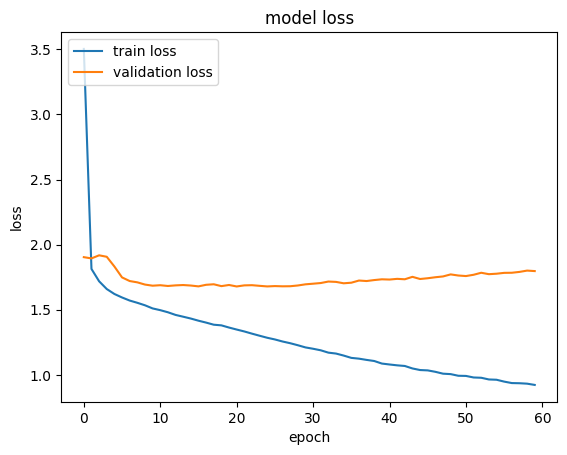

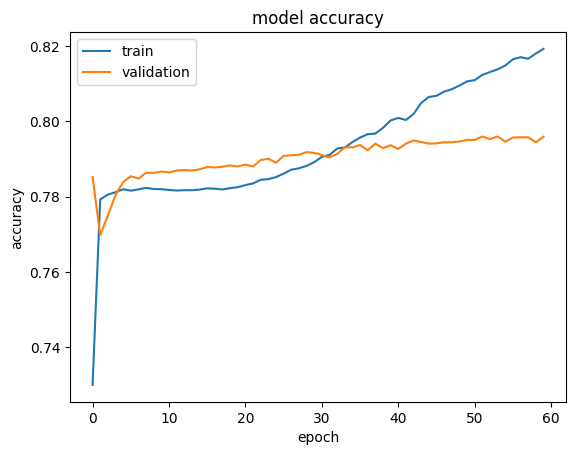

In [ ]:
#load our dictionary

# Load the dictionary from the file
with open('/content/att_history.json', 'r') as json_file:
    history = json.load(json_file)
plot_training_accuracy(history, savePlot=False, title = "fig")

In [ ]:
model = load_model('/content/poem_with_luoang_attention_v2.h5')
for layer in model.layers:
  print(layer.name)

input_2
input_1
embedding
lstm
lstm_1
dot
attention
dot_1
concatenate
dropout
batch_normalization
dense


In [ ]:

# encoder
encoder_input = model.input[0]
encoder_lstm_output, encoder_state_h, encoder_state_c = model.layers[3].output
encoder_lstm_states = [encoder_state_h, encoder_state_c]
encoder_model = Model(encoder_input, # input encoder model
                      [encoder_lstm_output, encoder_state_h, encoder_state_c]) # output encoder model


#decoder
decoder_input = model.input[1]
embeded_decoder = model.layers[2]
embeded_decoder = embeded_decoder(decoder_input)
decoder_state_h = Input(shape=(100), name="input_3")
decoder_state_c = Input(shape=(100), name="input_4")
decoder_state_inputs = [decoder_state_h, decoder_state_c]
decoder_lstm = model.layers[4]
decoder_output_lstm, state_h, state_c = decoder_lstm(embeded_decoder, initial_state=decoder_state_inputs)
decoder_states = [state_h,state_c]


#attention
encoder_out_as_input = Input(shape=(None, 100), name="input_5")
dot_layer = model.layers[5]
activation_dot_layer = model.layers[6]
attention = dot_layer([decoder_output_lstm, encoder_out_as_input])
attention = activation_dot_layer(attention)
dot_layer2 = model.layers[7]
context  = dot_layer2([attention, encoder_out_as_input])
conc_out = model.layers[8]
conc_out = conc_out([context, decoder_output_lstm])

#decoder output
dropout_out = model.layers[9]
dropout_out = dropout_out(conc_out)
batch_norm = model.layers[10]
dropout_out = batch_norm(dropout_out)
decoder_dense = model.layers[11]
decoder_outputs = decoder_dense(dropout_out)

decoder_model = Model([decoder_input, encoder_out_as_input, decoder_state_inputs], # input decoder model
                      [decoder_outputs]+decoder_states) # output decoder model



# Infference (Encoder decoder model with luoang attention and teacher forcing)

In [ ]:
def inference_with_attention(sentence,max_sequence_length,num_line):

    initial = sentence
    for i in range(num_line):
      sentence = sentence

    # Input the sequence to encoder_model and get the final timestep encoder_states(Hidden and cell state)
      tokens = tokenizer.word_tokenize(sentence)
      encoded_seed = [word_index.get(word, word) for word in tokens]
      max_sequence_length = max_sequence_length
      padded_seed = pad_sequences([encoded_seed], maxlen=max_sequence_length, padding='post')
      encoder_output,state_h, state_c = encoder_model.predict(padded_seed)

    # Define target word
      target_word = np.zeros((1,1))
    # :1 , :2
      target_word[0,0] = seq_start_token_id

      stop_condition=False
    # Define output sentence string
      sent=''
      step_size=0

    #index_to_words = {idx: word for word, idx in eng_text_tokenizer.word_index.items()}
      while not stop_condition:

        # We are giving a target_word which represents  and encoder_states to the decoder_model
        # for the first step and the output at the previous step for the next steps after the first
          output, state_h, state_c = decoder_model.predict([target_word,encoder_output, [state_h, state_c]])

        # As the target word length is 1. We will only have one time step
        #encoder_state_value = [state_h, state_c]
        # Find the word which the decoder predicted with max_probability
          output = np.argmax(output,-1)
        # The output is a integer sequence, to get back the word. We use our lookup table reverse_dict
        #sent = sent+' '+str(index_to_words.get(int(output)))
          word = [word for word, index in word_index.items() if index == output][0]
          sent = sent +' '+ word
          step_size+=1
        # If the max_length of the sequence is reached or the model predicted 2 () stop the model
          if step_size>max_sequence_length or output==seq_end_token_id:
            stop_condition = True
        # Define next decoder input
          target_word=output.reshape(1,1)

      sentence = sent
      #sentence = sentence.encode('utf-8')

      initial = initial + '\n' + sent
      #sentence = initial

    return initial

In [ ]:
inference_with_attention('হাতে হাত রেখে পাড়ি দেব', max_sequence_length,4)

1/1 [==============================] - 0s 31ms/step


'হাতে হাত রেখে পাড়ি দেব\n যেন , <\n আমার <\n আমার <\n আমার <'